# What does a population look like without the impact of the HIV/AIDS epidemic? What long-term affect will the AIDS epidemic have on the population of Sub-Saharan Africa?

Modeling and Simulation - Project 1

Skye Ozga, HK Rho


Disease obviously kills people in the short term, but we want to predict just how much an epidemic such as AIDS will affect population in the long term. To examine this problem, we will be looking at the southern region of Africa, broken down by country.

### Importing Libraries 

In [1]:
#import all the libraries
from modsim import *
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

#birth rate, population, and death rate data for 10 countries
BPDdata = pd.read_csv("BPD.csv", index_col = ['Year'], skiprows = 3, nrows = 57);

# What long-term affect will the AIDS epidemic have on the population of Sub-Saharan Africa?

Disease obviously kills people in the short term, but we want to predict just how much an epidemic such as AIDS will affect population in the long term. To examine this problem, we will be looking at the southern region of Africa, broken down by country.

### Importing Data and Organizing Variables

In [2]:
#the countries below are the 10 countries we are analyzing from Eastern/Southern Africa
country_list = ['Angola'    , 'Botswana', 'Eswatini'   , 'Lesotho' , 'Malawi', 
                'Mozambique', 'Namibia' , 'SouthAfrica', 'Zimbabwe', 'Zambia']

#years 1970-2030
T_START = 1980
T_1990  = 1990
T_2016  = 2016
T_2018  = 2018
T_END   = 2030
years = [x for x in range(1980,2017)];

#AIDS years: 1990-2016
years_AIDS = [x for x in range(1990,2017)];

## Building a model

We decided that because there are so many unknown and confounding variables that go into the spread of the disease, the best way to approach this question was to use the historical data availible and to break the region down by country to reduce some of the variance, and to make the most prominent parameter the presence or absence of AIDS.

In [3]:
class Country:
    
    def __init__(self, name, data = TimeSeries()):

        if not data.empty:
            #Initialize data for each country
            #br = birth rate
            #dr = death rate
            #da = deaths due to AIDS
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            
            
            #pop[T_START] is initial population parameter
            self.pop_data  = TimeSeries()
            
            
            #reads data from main spreadsheet 
            for t in range(T_START, T_2016 + 1):
                self.br_data[t] = data[name + 'BR'][t]
            for t in range(T_START, T_2016 + 1):
                self.da[t] = data[name + 'DA'][t]
            for t in range(T_START, T_2016 + 1):
                self.dr_data[t] = data[name + 'DR'][t]
            for t in range(T_START, T_2016 + 1):
                self.pop_data[t] = data[name + 'Pop'][t]
                
                
            #br and dr in arrays bc numpy doesn't like dataframes
            self.br_array  = [self.br_data[y] for y in years]
            self.dr_array  = [self.dr_data[y] for y in years]
            
            
            #Initializes population state variable
            self.pop       = TimeSeries()
        
        
            #generate br/dr models from linear fit of data
            self.br_AIDS_model = TimeSeries()
            m1, b1 = np.polyfit(years, self.br_array,1)
            for t in linrange(T_START, T_END+1):
                self.br_AIDS_model[t] = m1*(t) + b1
        
            self.dr_AIDS_model = TimeSeries()
            m2, b2 = np.polyfit(years, self.dr_array,1)
            for t in linrange(T_START, T_END+1):
                self.dr_AIDS_model[t] = m2*(t) + b2
                
            
            #modify br/dr data to eliminate AIDS-related deaths
            self.br_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.br_noAIDS[t] = self.br_data[t]
                if t >= T_1990:
                    self.br_noAIDS[t] = self.br_data[t] + self.br_data[t] * self.da[t]/(self.pop_data[t])
            
            self.dr_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.dr_noAIDS[t] = self.dr_data[t]
                if t >= T_1990: 
                    self.dr_noAIDS[t] = self.dr_data[t] - 1000.0*self.da[t]/self.pop_data[t]

                    
            #once again, numpy doesn't like DataFrames
            self.br_array_noAIDS  = [self.br_noAIDS[y] for y in years]
            self.dr_array_noAIDS  = [self.dr_noAIDS[y] for y in years]
            
            
            #linear fit for modified br/dr data
            self.br_noAIDS_model = TimeSeries()
            m3, b3 = np.polyfit(years, self.br_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.br_noAIDS_model[t] = m3*(t) + b3
        
            self.dr_noAIDS_model = TimeSeries()
            m4, b4 = np.polyfit(years, self.dr_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.dr_noAIDS_model[t] = m4*(t) + b4
                
                
        else:
            
            #pseudo-overloaded constructor to make a blank country object
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            self.pop_data  = TimeSeries()
            self.br_array  = [0]
            self.dr_array  = [0]
            self.pop       = TimeSeries()
        
            self.br_AIDS_model   = TimeSeries()
            self.dr_AIDS_model   = TimeSeries()
            self.br_noAIDS_model = TimeSeries()
            self.dr_noAIDS_model = TimeSeries()
            
    def update(self, t, aids = True):
        #start by making the state population 
        #equal to the system starting population
        if t == T_START:
            self.pop[t] = self.pop_data[t]
            return self.pop[t]
        
        #This is so that the TimeSeries knows it's getting another value
        self.pop[t] = self.pop[t-1]
        delta = 0
        
        #updates the population based on the br/dr of the respective model
        #(AIDS or no AIDS)
        if aids:
            delta = self.pop[t-1]*(self.br_AIDS_model[t] - self.dr_AIDS_model[t])/1000
        else:
            delta = self.pop[t-1]*(self.br_noAIDS_model[t] - self.dr_noAIDS_model[t])/1000
        
        
        #spits out the updated population data
        self.pop[t] += delta
        return self.pop[t]

Let's create an array of all of our countries, as well as a cumulative Country object to represent the region as a whole.

In [4]:
#generates all the Country Objects
countries = [Country(c, BPDdata) for c in country_list];


#generates a blank 'Country' with the to keep track of totals for the region
total = Country('Cumulative')

#sum all the population and AIDS death data
for t in range(T_START, T_2016+1):
    total.da[t]        = 0.0
    total.pop_data[t]  = 0.0
    for c in countries:
            total.pop_data[t] += c.pop_data[t]
            total.da[t]       += c.da[t]

#average the BR and DR data
for t in range(T_START, T_2016+1):
    total.br_data[t]          = 0.0
    total.dr_data[t]          = 0.0
    
    for c in countries:
        total.br_data[t]          += c.br_data[t]*c.pop_data[t]/total.pop_data[t]
        total.dr_data[t]          += c.dr_data[t]*c.pop_data[t]/total.pop_data[t]
    
#average the BR and DR models        
for t in range(T_START, T_END+1):
    total.br_AIDS_model[t]   = 0.0
    total.dr_AIDS_model[t]   = 0.0
    total.br_noAIDS_model[t] = 0.0
    total.dr_noAIDS_model[t] = 0.0
    
    for c in countries:
        total.br_AIDS_model[t]   += c.br_AIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.dr_AIDS_model[t]   += c.dr_AIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.br_noAIDS_model[t] += c.br_noAIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.dr_noAIDS_model[t] += c.dr_noAIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]

#add the region to the countries array
countries.append(total)

### Looking at the data for birthrate and deathrate to turn the data into a model

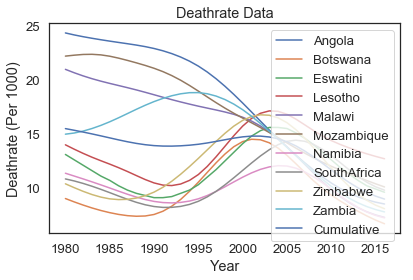

In [5]:
for c in countries:
    plt.plot(c.dr_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Deathrate Data')

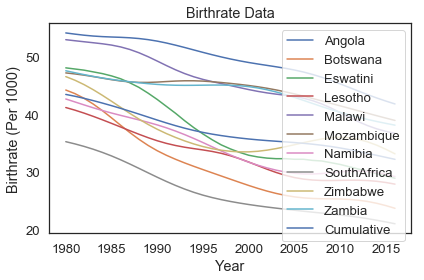

In [6]:
for c in countries:
    plt.plot(c.br_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Data')

As you can see, birthrates and deathrates are generally decreasing, with a large spike in deaths between 1990 and 2015 (the height of the epidemic). We decided that a linear model for each of these parameters would be best for the sake of simplicity, however a more realistic model may use a negative exponential or similar function in order to avoid ending up with negative deathrates and birthrates as the model is extrapolated to later years.

# Regression Model for Birthrates and Deathrates
In order to create the linear functions for birth and deathrates, we used a least squares regression line. To walk through the process, let's look at Malawi. First we modeled our control after the existing data (with AIDS).

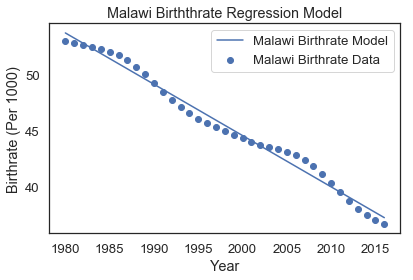

In [7]:
malawi = countries[4]

plt.scatter(years, malawi.br_array, label = 'Malawi Birthrate Data')

#find LSRL of data
m, b = np.polyfit(years, malawi.br_array,1)

#create a TimeSeries to store the modeled birthrate
malawi_br = TimeSeries()

#fill said time series based off of the LSRL equation
for t in linrange(T_START, T_2016+1):
    malawi_br[t] = m*(t) + b
    
    
plt.plot(malawi_br, label = 'Malawi Birthrate Model')
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Malawi Birththrate Regression Model')

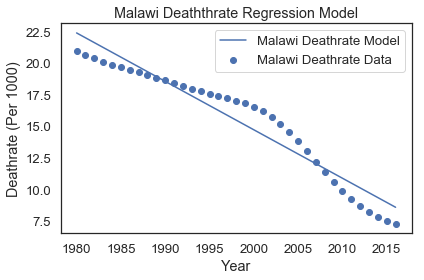

In [8]:
plt.scatter(years, malawi.dr_array, label = 'Malawi Deathrate Data')
m, b = np.polyfit(years, malawi.dr_array,1)
malawi_dr = TimeSeries()
for t in linrange(T_START, T_2016+1):
    malawi_dr[t] = m*(t) + b
plt.plot(malawi_dr, label = 'Malawi Deathrate Model')
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Malawi Deaththrate Regression Model')

To get our experimental model (without AIDS) the next step we took was to modify the data, factoring out the effects of the deaths caused by the AIDS epidemic. 

To do so we took the data on the deaths and subtracted those deaths from the death rate \[modifiedDR = DR - 1000 * (AIDSdeaths / population)\] (deathrate per 1000 people minus the death rate per person due to AIDS times 1000 people to get death rate per 1000)

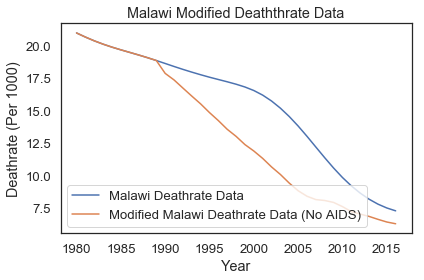

In [9]:
plt.plot(years, malawi.dr_array, label = 'Malawi Deathrate Data')
malawi_dr_noAIDS = TimeSeries()
for t in linrange(T_START, T_2016+1):
    #same dr before AIDS epidemic starts in 1990
    malawi_dr_noAIDS[t] = malawi.dr_data[t]
    
    #modify data after 1990
    if t >= T_1990: 
        malawi_dr_noAIDS[t] = malawi.dr_data[t] - 1000.0*malawi.da[t]/malawi.pop_data[t]
        
plt.plot(years, malawi_dr_noAIDS, label = 'Modified Malawi Deathrate Data (No AIDS)')
        
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Malawi Modified Deaththrate Data')

The birthrate is also modified because we made the assumption that a proportion of the people who die from AIDS each year could have potentially given birth. We assumed that this was inline with the whole country's birthrate, however more demographic data would be needed to validate this. The birthrate data was modified using the equation \[modifiedBR = BR + BR*(AIDSdeaths/populaiton)\] (Birthrate plus the assumed birthrate (same as from data) times the proportion of people who died due to AIDS). As you can see, it was not nearly as dramatic a change as in deathrate, however it was still noticeable.

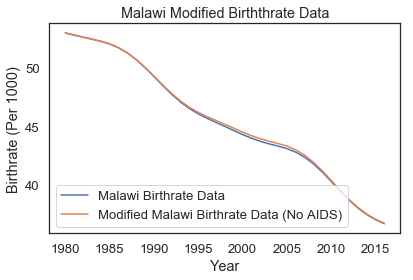

In [10]:
plt.plot(years, malawi.br_array, label = 'Malawi Birthrate Data')
malawi_br_noAIDS = TimeSeries()
for t in linrange(T_START, T_2016+1):
    #same dr before AIDS epidemic starts in 1990
    malawi_br_noAIDS[t] = malawi.br_data[t]
    
    #modify data after 1990
    if t >= T_1990: 
        malawi_br_noAIDS[t] = malawi.br_data[t] + malawi.br_data[t] * malawi.da[t]/(malawi.pop_data[t])
        
plt.plot(years, malawi_br_noAIDS, label = 'Modified Malawi Birthrate Data (No AIDS)')
        
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Malawi Modified Birththrate Data')

Using this modified data, we found new regression lines to build the model without AIDS.

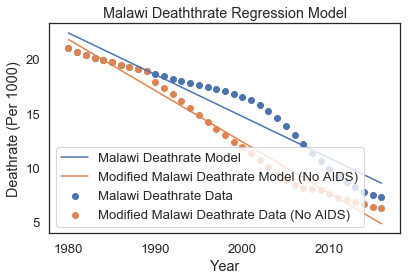

In [11]:
plt.scatter(years, malawi.dr_array, label = 'Malawi Deathrate Data')
plt.scatter(years, malawi_dr_noAIDS, label = 'Modified Malawi Deathrate Data (No AIDS)')

m1, b1 = np.polyfit(years, malawi.dr_array,1)
malawi_dr = TimeSeries()
for t in linrange(T_START, T_2016+1):
    malawi_dr[t] = m1*(t) + b1
plt.plot(malawi_dr, label = 'Malawi Deathrate Model')

m2, b2 = np.polyfit(years, malawi.dr_array_noAIDS,1)
malawi_dr_noAIDS_model = TimeSeries()
for t in linrange(T_START, T_2016+1):
    malawi_dr_noAIDS_model[t] = m2*(t) + b2
plt.plot(malawi_dr_noAIDS_model, label = 'Modified Malawi Deathrate Model (No AIDS)')
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Malawi Deaththrate Regression Model')

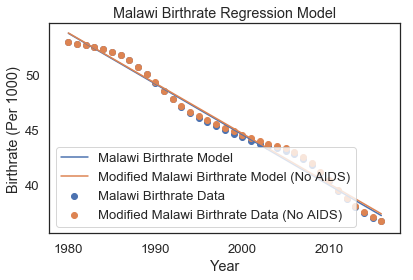

In [12]:
plt.scatter(years, malawi.br_array, label = 'Malawi Birthrate Data')
plt.scatter(years, malawi_br_noAIDS, label = 'Modified Malawi Birthrate Data (No AIDS)')

m1, b1 = np.polyfit(years, malawi.br_array,1)
malawi_br = TimeSeries()
for t in linrange(T_START, T_2016+1):
    malawi_br[t] = m1*(t) + b1
plt.plot(malawi_br, label = 'Malawi Birthrate Model')

m2, b2 = np.polyfit(years, malawi.br_array_noAIDS,1)
malawi_br_noAIDS_model = TimeSeries()
for t in linrange(T_START, T_2016+1):
    malawi_br_noAIDS_model[t] = m2*(t) + b2
plt.plot(malawi_br_noAIDS_model, label = 'Modified Malawi Birthrate Model (No AIDS)')
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Malawi Birthrate Regression Model')

Now let's do this for all the other countries!

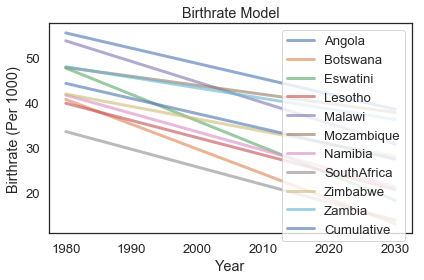

In [13]:
for c in countries:
    plot(c.br_AIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Model')


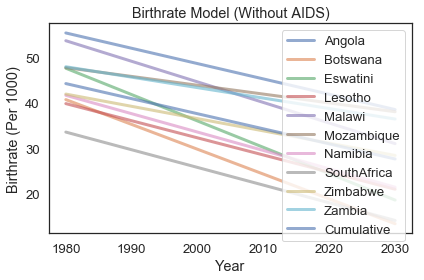

In [14]:
for c in countries:
    plot(c.br_noAIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Model (Without AIDS)')

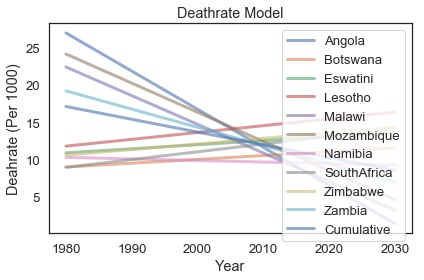

In [15]:
for c in countries:
    plot(c.dr_AIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deahrate (Per 1000)',
             title='Deathrate Model')

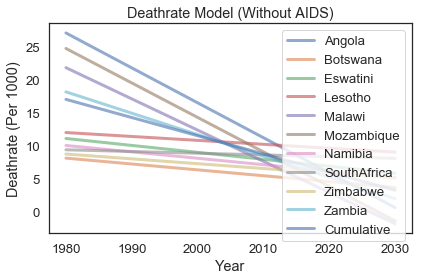

In [16]:
for c in countries:
    plot(c.dr_noAIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Deathrate Model (Without AIDS)')

# Building the Simulation

Now that we have all the parameters we need for our model, it is time to turn the model into a simulation. The most important step in that process is the update function. Our update function is located within the Country class because that's where it has easiest access to the state variables. Essentially what it does is it takes the parameters of the **Country** (Country object), the **Year** (int), and whether or not the **AIDS** epidemic exists in this simulated world (bool). The Country is passed implicitly, as this is a method of the class, so that detemines which system's state it is accessing, and the AIDS parameter changes the functionality of the method, choosing between which birthrate/deathrate models to use, and the year parameter keeps track of the index of the Population time series. The update function calculates the change in population by multiplying the current population by the difference between the birthrate and deathrate and then adds that change to the current population \[pop = pop*(br - dr)\]

The update function is called within the run simulation function, which takes a **Country** object, a boolean representing the presence of **AIDS**, and **Start** and **End** times which can be modified, but default to the globally defined start and end times of 1980 and 2030 that we happen to be using. This essentially just runs through the update function for every year between the start and the end time and then plots the results (which are stored by the Country object)

In [17]:
def run_simulation(country, aids = True, start = T_START, end = T_END):
    #get the results
    for t in range(start, end+1):
        country.update(t, aids)
    
    #plot the results
    if aids:
        plt.plot(country.pop, label = country.name + ' With AIDS')
    else:
        plt.plot(country.pop, label = country.name + ' Without AIDS')

Now we can easily simulate the population of each country 

both with AIDS...

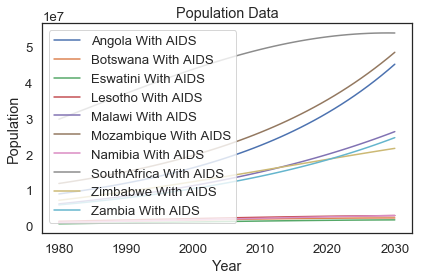

In [18]:
for i in range(10):
    run_simulation(countries[i], True)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

and without!

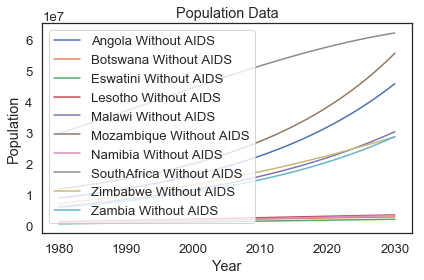

In [19]:
for i in range(10):
    run_simulation(countries[i], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

# Results
The model we created allows us to easily see the effect that the AIDS epidemic has had on the population of an individual country:

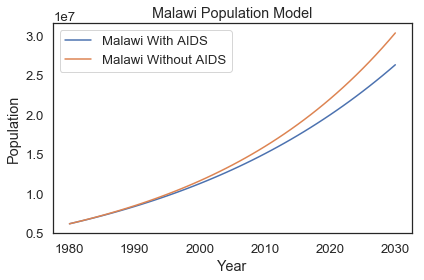

In [20]:
run_simulation(countries[4], True)
run_simulation(countries[4], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Malawi Population Model')

and on the region as a whole:

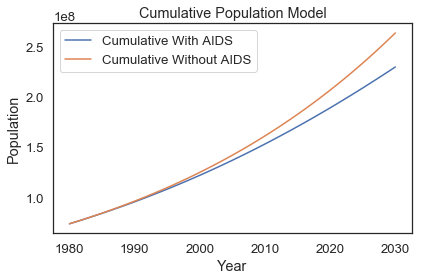

In [21]:
run_simulation(countries[10], True)
run_simulation(countries[10], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Cumulative Population Model')

Furthermore, when we plot the data against the model that we made for real life (with AIDS) we can see that this model is a much better fit for some countries

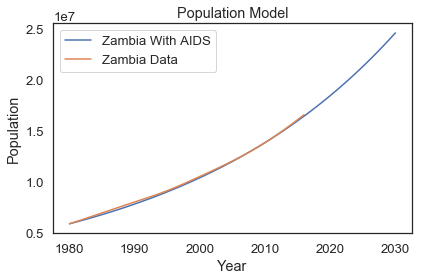

In [22]:
run_simulation(countries[9], True)
plt.plot(countries[9].pop_data, label = countries[9].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

Than it is for others

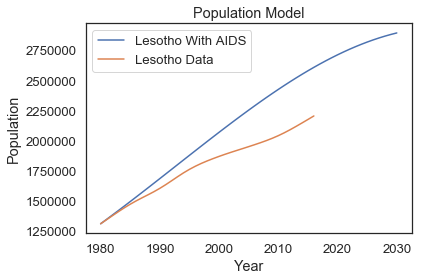

In [23]:
run_simulation(countries[3], True)
plt.plot(countries[3].pop_data, label = countries[3].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

However, overall it evens out very nicely.

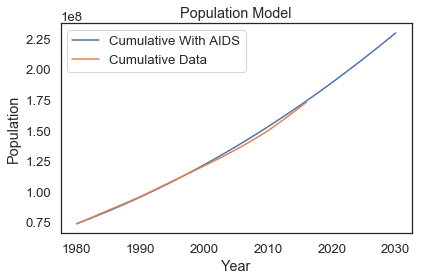

In [24]:
run_simulation(countries[10], True)
plt.plot(countries[10].pop_data, label = countries[10].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

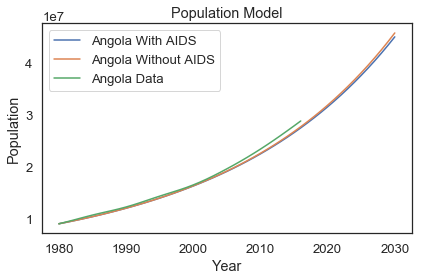

In [25]:
run_simulation(countries[0], True)
run_simulation(countries[0], False)
plt.plot(countries[0].pop_data, label = countries[0].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

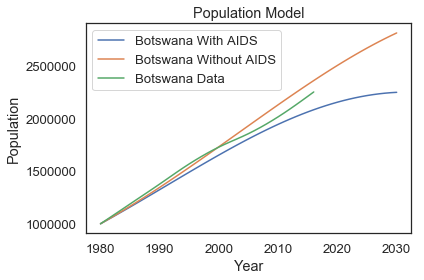

In [26]:
run_simulation(countries[1], True)
run_simulation(countries[1], False)
plt.plot(countries[1].pop_data, label = countries[1].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

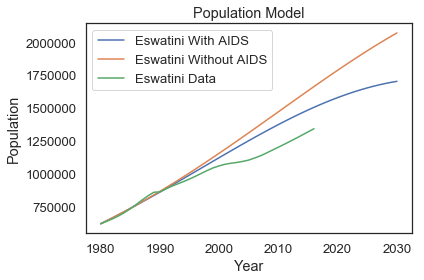

In [27]:
run_simulation(countries[2], True)
run_simulation(countries[2], False)
plt.plot(countries[2].pop_data, label = countries[2].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

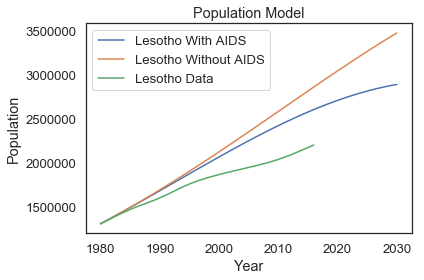

In [28]:
run_simulation(countries[3], True)
run_simulation(countries[3], False)
plt.plot(countries[3].pop_data, label = countries[3].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

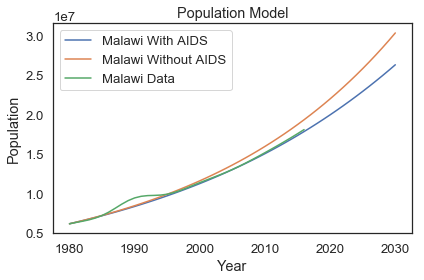

In [29]:
run_simulation(countries[4], True)
run_simulation(countries[4], False)
plt.plot(countries[4].pop_data, label = countries[4].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

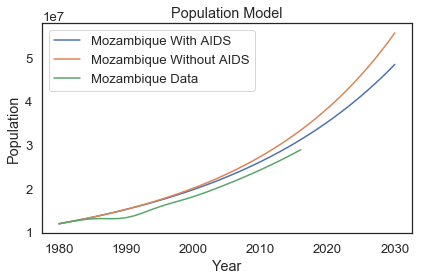

In [30]:
run_simulation(countries[5], True)
run_simulation(countries[5], False)
plt.plot(countries[5].pop_data, label = countries[5].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

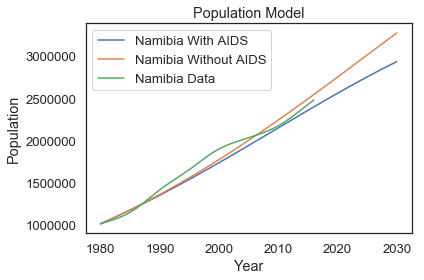

In [31]:
run_simulation(countries[6], True)
run_simulation(countries[6], False)
plt.plot(countries[6].pop_data, label = countries[6].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

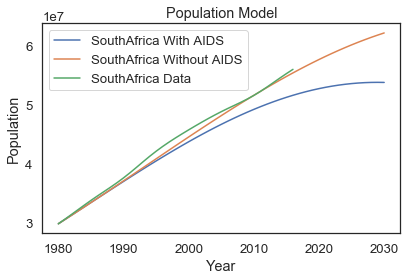

In [32]:
run_simulation(countries[7], True)
run_simulation(countries[7], False)
plt.plot(countries[7].pop_data, label = countries[7].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

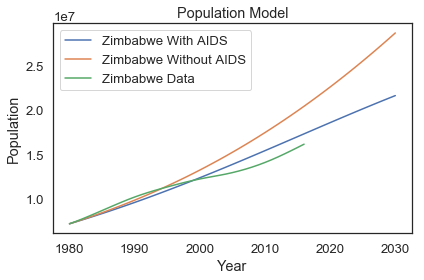

In [33]:
run_simulation(countries[8], True)
run_simulation(countries[8], False)
plt.plot(countries[8].pop_data, label = countries[8].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

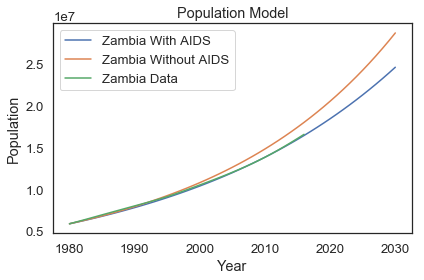

In [34]:
run_simulation(countries[9], True)
run_simulation(countries[9], False)
plt.plot(countries[9].pop_data, label = countries[9].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

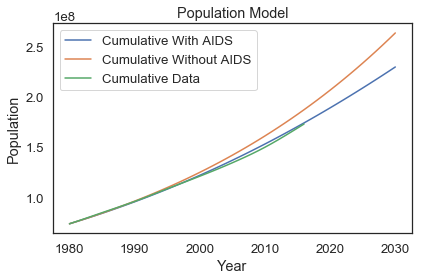

In [35]:
run_simulation(countries[10], True)
run_simulation(countries[10], False)
plt.plot(countries[10].pop_data, label = countries[10].name + ' Data')

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

# Interpretation
Looking accross all the data...

% Difference Between Models With and Without AIDS

2018:
Angola : 0.8984766103581691 %
Botswana : 14.693276046369231 %
Eswatini : 11.759025626146338 %
Lesotho : 11.046048158528432 %
Malawi : 9.237841215917875 %
Mozambique : 7.90073071242559 %
Namibia : 6.794492846946689 %
SouthAfrica : 8.346020047743957 %
Zimbabwe : 19.78585978462977 %
Zambia : 10.425844413944942 %
Cumulative : 8.400795676344687 %

2030:
Angola : 1.674485756583639 %
Botswana : 25.04899205222733 %
Eswatini : 21.57917729970065 %
Lesotho : 20.211875014695774 %
Malawi : 15.33208983411828 %
Mozambique : 14.932363522986005 %
Namibia : 11.59321437665343 %
SouthAfrica : 15.64264281017953 %
Zimbabwe : 32.70629055285558 %
Zambia : 16.67415235130167 %
Cumulative : 14.72958063472869 %


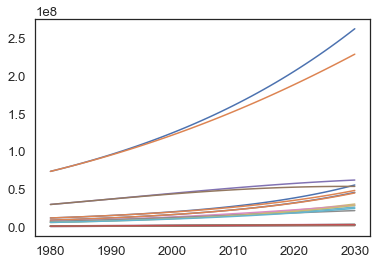

In [36]:
delta2030 = []
delta2018 = []
for i in range(11):
    run_simulation(countries[i], False);
    no_aids2030 = countries[i].pop[T_END]
    no_aids2018 = countries[i].pop[T_2018]
    run_simulation(countries[i], True);
    aids2030 = countries[i].pop[T_END]
    aids2018 = countries[i].pop[T_2018]
    delta2018.append(no_aids2018 - aids2018)
    delta2030.append(no_aids2030 - aids2030)
    
print('% Difference Between Models With and Without AIDS')
print('')
print(str(T_2018) + ":")
for i in range (11):
    print(countries[i].name + ' : ' + str(100*delta2018[i]/countries[i].pop[T_2018]) + ' %')
print("")
print(str(T_END) + ":")
for i in range (11):
    print(countries[i].name + ' : ' + str(100*delta2030[i]/countries[i].pop[T_END]) + ' %')

Our model shows that some countries (Zimbabwe and Botswana) were hit significantly harder by the epidemic than others (Angola and Namibia). This confirms our hypothesis that due to a number of confounding factors, the region will be affected nonuniformly. In addition, looking at the how the differences between the models with and without AIDS change over time reveals just how big of an impact a short term loss of life can make in the long run. Although we may be down a total 8 percent from the potential population of southern Africa solely because of AIDS, within less than half the time since the epidemic started, that figure could double, assuming our model is correct.

The largest takeaway from this model should be that in the situation of an epidemic, we should work as quickly as possible and target the highest risk areas in order to save the most lives in the long run.